# Régression & optimisation par descente de gradient

Ce tme a deux objectifs: 
 - acquérir les connaissances de base pour faire face au problème de la régression, c'est à dire de l'estimation d'un score réel correpondant à une situation,
 - travailler sur les techniques d'optimisation par descente de gradient

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Génération de données jouet & construction d'une solution analytique

Dans un premier temps, générons des données jouets paramétriques:
 - $N$: nombre de points à générer
 - $x \in [0, 1]$ tirage avec un simple rand() ou un linspace() -au choix-
     - Si vous optez pour un tirage aléatoire des abscisses, triez les points pour simplifier les traitements ultérieurs
 - $y=ax+b+\epsilon, \epsilon \sim \mathcal N(0,\sigma^2)$
     - Rappel : en multipliant un tirage aléatoire selon une gaussienne centrée réduite par $\sigma$ on obtient le bruit décrit ci-dessus

Afin de travailler sur les bonnes pratiques, nous distinguerons un ensemble d'apprentissage et un ensemble de test.
Les deux sont tirés selon la même distribution. L'ensemble de test comptera -arbitrairement- 1000 points.

In [2]:
def gen_data_lin(a, b, sig, N=500, Ntest=1000):
    X_train = np.sort(np.random.rand(N))
    X_test  = np.random.rand(Ntest)
    Y_train = np.zeros((N))
    Y_test  = np.zeros((Ntest))
    X_train.sort()
    X_test.sort()
    mu = 0
    e = mu + sig * np.random.randn(N + Ntest)
    for n in range(N): # création du jeu d'apprentissage
        Y_train[n] = a * X_train[n] + b + e[n] # calcul des y
    for n in range(Ntest):# création du jeu de test
        Y_test[n] = a*X_test[n] + b + e[N+n] # calcul des y
    
    return X_train, Y_train, X_test, Y_test



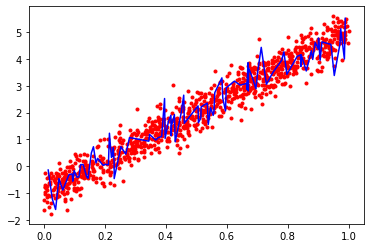

In [3]:
# génération de données jouets:
a = 6.
b = -1.
N = 100
sig = .4 # écart type

X_train, y_train, X_test, y_test = gen_data_lin(a, b, sig, N)

plt.figure()
plt.plot(X_test, y_test, 'r.')
plt.plot(X_train, y_train, 'b')

Vous devez obtenir quelque chose de la forme:
![données jouet](fig/gen_data.png)

## Validation des formules analytiques
Nous avons vu deux types de résolutions analytique: à partir des estimateurs des espérances et co-variances d'une part et des moindres carrés d'autre part. Testons les deux méthodes.

### Estimation de paramètres probabilistes
 - $\hat a = \frac{\mbox{cov}(X,Y)}{\sigma_x^2}$
 - $\hat b = E(Y)−\frac{\mbox{cov}(X,Y)}{\sigma_x^2} E(X)$
 
 Estimer les paramètres, calculer l'erreur au sens des moindres carrés sur les données d'apprentissage et de test, puis tracer la droite de régression

In [4]:
def modele_lin_analytique(X_train, y_train):
    # d'abord, l'estimation des paramètres
    ahat = np.cov(X_train,y_train)[0][1]/np.var(X_train) # application des formules
    bhat = np.mean(y_train) - ahat*np.mean(X_train)
    return ahat, bhat

ahat, bhat = modele_lin_analytique(X_train, y_train)
print(ahat, bhat)

5.932422997373358 -0.9354807223715509


In [5]:
def erreur_mc(y, yhat):
    return ((y-yhat)**2).mean()

yhat_train = ahat*X_train+bhat
yhat_test  = ahat*X_test+bhat

print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat_train, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_test, y_test))

Erreur moyenne au sens des moindres carrés (train): 0.18682948558302706
Erreur moyenne au sens des moindres carrés (test): 0.16037763474987743


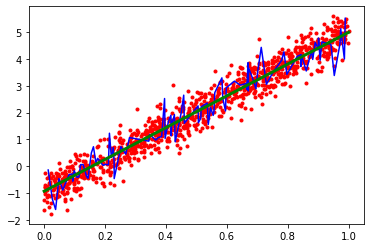

In [6]:
plt.figure()
plt.plot(X_test, y_test, 'r.')
plt.plot(X_train, y_train, 'b')
plt.plot(X_test, yhat_test, 'g', lw=3)

## Formulation au sens des moindres carrés

Nous partons directement sur une écriture matricielle. Du coup, il est nécessaire de construire la matrice enrichie $Xe$:
    $$Xe = \left[\begin{array}{cc}
                X_0 & 1\\
                \vdots & \vdots\\
                X_N & 1
                \end{array}
                \right] $$
Le code de la fonction d'enrichissement est donné ci-dessous.

Il faut ensuite poser et résoudre un système d'équations linéaires de la forme:
$$ A w = B $$
**Rappel des formules vues en cours/TD:**
$$ A=X^T X$$
$$ B=X^T Y$$
Fonction de résolution: `np.linalg.solve(A,B)`
Vous devez obtenir la même solution que précédemment. 

In [7]:
def make_mat_lin_biais(X): # fonctionne pour un vecteur unidimensionel X
    N = len(X)
    return np.hstack((X.reshape(N,1),np.ones((N,1))))

In [8]:
Xe = make_mat_lin_biais(X_train)
# A compléter
# résoudre un système Aw = B : trouver les coefficients de l'équation linéaire
A = np.dot(Xe.T, Xe) 
B = np.dot(Xe.T, y_train)
w = np.linalg.solve(A,B) 
print(w)

[ 5.87309877 -0.90647318]


Soit les données polynomiales générées avec la fonction ci-dessous
 - proposer & une solution d'enrichissement (vue en cours et TD) 
 - résoudre analytiquement le problème des moindres carrés
 - calculer l'erreur au sens des moindes carrés en apprentissage ET en test
 - tracer les données et la solution

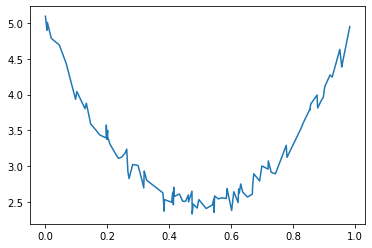

In [9]:
def gen_data_poly2(a, b, c, sig, N=500, Ntest=1000):
    '''
    Tire N points X aléatoirement entre 0 et 1 et génère y = ax^2 + bx + c + eps
    eps ~ N(0, sig^2)
    '''
    X_train = np.sort(np.random.rand(N))
    X_test  = np.sort(np.random.rand(Ntest))
    y_train = a*X_train**2+b*X_train+c+np.random.randn(N)*sig
    y_test  = a*X_test**2 +b*X_test +c+np.random.randn(Ntest)*sig
    return X_train, y_train, X_test, y_test

Xp_train, yp_train, Xp_test, yp_test = gen_data_poly2(10, -10, 5, 0.1, N=100, Ntest=100)
plt.figure()
plt.plot(Xp_train, yp_train)

Erreur moyenne au sens des moindres carrés (train): 0.022752598222821604
Erreur moyenne au sens des moindres carrés (test): 0.02671161521329223


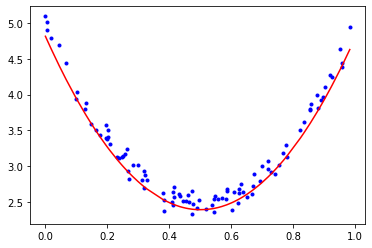

In [10]:
def make_mat_poly_biais(X): # fonctionne pour un vecteur unidimensionel X
    # A compléter
    N = len(X)
    Xr = X.reshape(N,1)
    return np.hstack((Xr**2, Xr, np.ones((N,1)))) # empiler les termes de degré 2, de degré 1, de degré 0


Xe   = make_mat_poly_biais(X_train)
Xe_t = make_mat_poly_biais(X_test)
#ensuite on résout le système comme précédemment
A = np.dot(Xe.T, Xe)
B = np.dot(Xe.T, yp_train)
w = np.linalg.solve(A, B)

yhat = w[0]*Xp_train**2 + w[1]*Xp_train + w[2]
yhat_t = w[0]*Xp_test**2 + w[1]*Xp_test + w[2]
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat, yp_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t, yp_test))

plt.figure()
plt.plot(Xp_train, yp_train, 'b.')
plt.plot(Xp_train, yhat, 'r')

# Fonction de coût & optimisation par descente de gradient

Comme vu en TD et en cours, nous allons maintenant résoudre le problème de la régression par minimisation d'une fonction de coût:
$$ C = \sum_{i=1}^N (y_i - f(x_i))$$

Soit un problème avec des données $(x_i,y_i)_{i=1,\ldots,N}$, une fonction de décision/prédiction paramétrée par un vecteur $w$ et une fonction de cout à optimiser $C(w)$.
Notre but est de trouver les paramètres $w^\star$ minimisant la fonction de coût:
$$ w^\star = \arg\min_w C(w)$$

l'algorithme de la descente de gradient est le suivant (rappel):

 - $w_0 \leftarrow init$ par exemple : 0
 - boucle
     - $w_{t+1} \leftarrow w_{t} - \epsilon \nabla_w C(w_t)$

Compléter le squelette d'implémentation fourni ci-dessous:


In [11]:
# pour travailler en matrice: (re)construction de la matrice contenant les X et un biais
Xe = make_mat_lin_biais(X_train) # dataset linéaire, transformation lineaire des données
A = np.dot(Xe.transpose(),Xe)
B = np.dot(Xe.transpose(),y_train)
# obtenir un w optimal à l'instant t
wstar = np.linalg.solve(A,B) 

def descente_grad_mc(X, y, eps=1e-4, nIterations=100):
    w = np.zeros(X.shape[1]) # init à 0
    allw = [w]
    for i in range(nIterations):
        Xw_y = np.dot(X,allw[-1]) - y
        w = allw[-1] - eps*np.dot(2*X.T, Xw_y)
        allw.append(w) # stockage de toutes les valeurs intermédiaires pour analyse
    allw = np.array(allw)
    return w, allw # la dernière valeur (meilleure) + tout l'historique pour le plot
    
w, allw = descente_grad_mc(Xe, y_train, eps=1e-4, nIterations=200)

On s'intéresse ensuite à comprendre la descente de gradient dans l'espace des paramètres. Le code ci-dessous permet de tracer le cout pour un ensemble de paramètres (toutes les valeurs de paramètres prises par l'algorithmes au fil du temps).


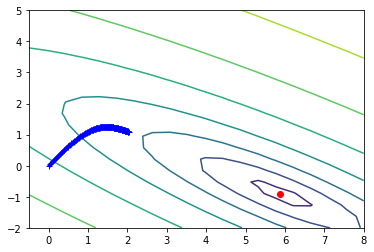

In [12]:
# tracer de l'espace des couts
def plot_parametres( allw, X, y, opti = [], ngrid = 20, extract_bornes=False):
    '''
    Fonction de tracer d'un historique de coefficients
    ATTENTION: ca ne marche qu'en 2D (évidemment)
    Chaque w doit contenir 2 valeurs
    
    Il faut fournir les données (X,y) pour calculer le cout associé 
    à un jeu de paramètres w
    ATTENTION X = forme matricielle des données
    '''
    w_min = [-0.5, -2] # bornes par défaut, uniquement pour notre cas d'usage
    w_max = [8, 5]
    if extract_bornes: # bornes générales
        w_min = np.min(allw,0) # trouver les bornes
        w_max = np.max(allw,0)
    # faire une grille régulière avec tous les couples possibles entre le min et le max
    w1range = np.linspace(w_min[0], w_max[0], ngrid)
    w2range = np.linspace(w_min[1], w_max[1], ngrid)
    w1,w2 = np.meshgrid(w1range,w2range)
    #
    # calcul de tous les couts associés à tous les couples de paramètres
    cost = np.array([[np.log(((X @ np.array([w1i,w2j])-y)**2).sum()) for w1i in w1range] for w2j in w2range])
    #
    plt.figure()
    plt.contour(w1, w2, cost)
    if len(opti) > 0:
        plt.scatter(wstar[0], wstar[1],c='r')
    plt.plot(allw[:,0],allw[:,1],'b+-' ,lw=2 )
    return
    
plot_parametres( allw, Xe, y_train, opti=wstar)
# plt.savefig('fig/grad_descente.png')

Vous devez obtenir un image de la forme :
![Descente de gradient](fig/grad_descente.png)

Tester différents jeux de paramètres pour mettre en évidence les phénomènes suivants:
 - Divergence du gradient
 - Convergence incomplète (trop lente ou pas assez d'itération)
 - Convergence idéale: pas de gradient suffisamment grand et nombre d'itérations bien choisi

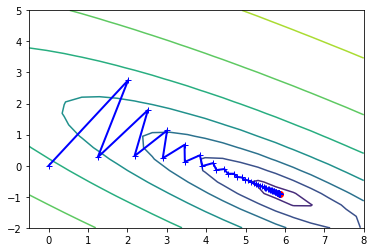

In [13]:
# presque une situation de divergence
w, allw = descente_grad_mc(Xe, y_train, eps=7e-3, nIterations = 300) 
plot_parametres(allw, Xe, y_train, opti=wstar)

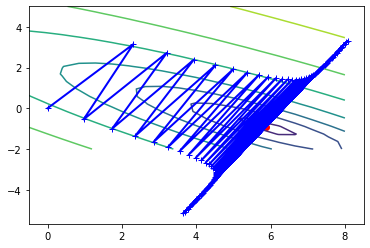

In [14]:
#convergence incomplète 
w, allw = descente_grad_mc(Xe, y_train, eps = 8e-3, nIterations = 100) 
plot_parametres(allw, Xe, y_train, opti=wstar)

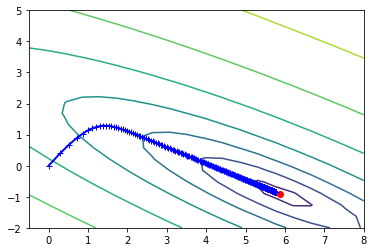

In [15]:
# convergence idéale
w, allw = descente_grad_mc(Xe, y_train, eps = 1e-3, nIterations = 300)
plot_parametres(allw, Xe, y_train, opti=wstar)


# Passage sur des données réelles

Après avoir étudié trois manières de faire face au problème de la régression, nous proposons d'étudier un cas réel: la prédiction de la consommation des voitures en fonction de leurs caractéristiques.

Dans le cas présent, nous allons baser la solution sur la résolution analytique du problème des moindres carrés (`np.linalg.solve(A,B)`), qui semble la mieux adaptée au problème qui nous intéresse.

Le jeu de données est issu des datasets UCI, un répertoire parmi les plus connus en machine learning. Les données **sont déjà téléchargées et présentes dans le tme** mais vous voulez plus d'informations:
https://archive.ics.uci.edu/ml/datasets/auto+mpg

![voiture](fig/Large9.jpg)

Après avoir importé les données (fonction fournie), vous construirez une solution optimale et l'évaluerez au sens des moindres carrés en apprentissage et en test.


In [16]:
import pandas as pd
# Chargement des données
data = pd.read_csv('data/auto-mpg.data', delimiter='\s+', header=None) # comme np.loadtxt mais en plus robuste
# remplacement des données manquantes '?' => Nan pour travailler sur des nombres
data.iloc[:,[3]] = data.iloc[:,[3]].replace('?', None)
data.iloc[:,[3]] = data.iloc[:,[3]].astype(float)
# remplacement des valeurs manquantes par la moyenne
data.iloc[:,[3]] = data.iloc[:,[3]].fillna(data.iloc[:,[3]].mean())

print(data.head()) # visualiser ce qu'il y a dans les données

X = np.array(data.values[:,1:-2], dtype=np.float64)
y = np.array(data.values[:,0], dtype=np.float64)


      0  1      2      3       4     5   6  7                          8
0  18.0  8  307.0  130.0  3504.0  12.0  70  1  chevrolet chevelle malibu
1  15.0  8  350.0  165.0  3693.0  11.5  70  1          buick skylark 320
2  18.0  8  318.0  150.0  3436.0  11.0  70  1         plymouth satellite
3  16.0  8  304.0  150.0  3433.0  12.0  70  1              amc rebel sst
4  17.0  8  302.0  140.0  3449.0  10.5  70  1                ford torino


In [17]:
# separartion app/test
def separation_train_test(X, y, pc_train=0.75):
    # A compléter
    # 1) générer tous les index entre 0 et N-1
    index = list(range(len(y)))
    # 2) mélanger la liste
    np.random.shuffle(index)
    napp = int(len(y)*pc_train) # nb de points pour le train
    X_train, y_train = X[index[:napp]], y[index[:napp]]
    X_test, y_test   = X[index[napp:]], y[index[napp:]]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = separation_train_test(X, y, pc_train=0.75)

In [18]:
# Résolution analytique
def make_mat_lin_biais(X): # fonctionne pour un vecteur unidimensionel X
    N = len(X)
    return np.hstack((X.reshape(N,1),np.ones((N,1))))

def make_mat_lin_biaisV2(X): # même chose que la fonction original sauf qu'elle est adaptée sur plusieurs colonnes
    N, M = X.shape
    return np.hstack((X.reshape(N,M),np.ones((N,1))))

Xe = make_mat_lin_biaisV2(X_train.copy())
Xe_t = make_mat_lin_biaisV2(X_test.copy())
Ye = y_train
A = np.dot(Xe.T, Xe)
B = np.dot(Xe.T, Ye)
w = np.linalg.solve(A, B)
print(w)
yhat = np.dot(Xe,w)
yhat_t = np.dot(Xe_t,w)
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t, y_test))


[-5.64732697e-01  1.70449451e-02  7.81988323e-03 -7.74016539e-03
  1.85488406e-01  7.26298081e-01 -1.27242999e+01]
Erreur moyenne au sens des moindres carrés (train): 11.209283917779977
Erreur moyenne au sens des moindres carrés (test): 13.46747406843026


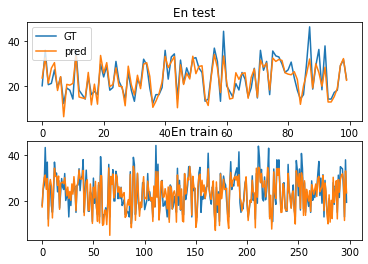

In [19]:
def plot_y(y_train, y_test, yhat, yhat_t):
    # tracé des prédictions:
    plt.figure()
    plt.subplot(211)
    plt.plot(y_test, label="GT")
    plt.plot(yhat_t, label="pred")
    plt.title('En test')
    plt.legend()
    plt.subplot(212)
    plt.plot(y_train, label="GT")
    plt.plot(yhat, label="pred")
    plt.title('En train')
    return
plot_y(y_train, y_test, yhat, yhat_t)

<BarContainer object of 7 artists>

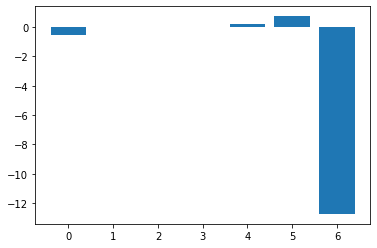

In [20]:
# interprétation des poids
plt.figure()
plt.bar(np.arange(len(w)), w)

## Normalisation

Sur le diagramme ci-dessus, on ne voit pas grand chose pour une raison évidente: on ne peut pas comparer ces poids qui comparent des variables dont les ordres de grandeur sont différents.

Nous allons donc assimiler chaque colonne $X_j$ à une variable suivant une loi normale et nous allons revenir à une Normale centrée réduite selon la formule de base:

$$X_j \sim \mathcal N(\mu_j, \sigma_j^2) $$
$$\Rightarrow Z_j = \frac{X_j - \mu_j}{\sigma_j} \sim \mathcal N(0, 1) $$

Tous les $Z_j$ sont comparables et nous seront en mesure de comprendre l'impact de chaque variables sur les résultats.

**ATTENTION:** on ne se basera que sur les données d'apprentissage pour le calcul des $\{\mu_j, \sigma_j\}$.

Une fois la normalisation effectuée, analyser l'impact des différentes variables descriptives sur la valeur à prédire.

Erreur moyenne au sens des moindres carrés (train): 11.209283917779977
Erreur moyenne au sens des moindres carrés (test): 13.46747406843038


<BarContainer object of 7 artists>

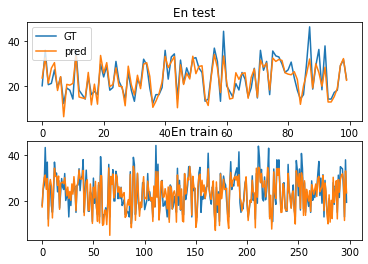

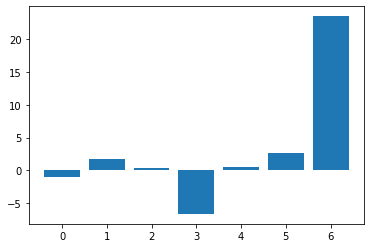

In [21]:
def normalisation(X_train, X_test):
    '''
    Fonction de normalisation des données pour rendre les colonnes comparables
    Chaque variable sera assimilée à une loi normale qu'il faut centrer + réduire.
    ATTENTION: il faut calculer les moyennes et écarts-types sur les données d'apprentissage seulement
    '''
    # A compléter
    # 1) calcul des moyennes et écarts types pour chaque colonne
    # 2) normalisation des colonnes
    # 3) Ajout d'un biais: fourni ci-dessous)
    Xn_train = np.zeros(X_train.shape)
    Xn_test = np.zeros(X_test.shape)
    for i in range(X_train.shape[1]):
        #calculer la moyenne de toute la colonne
        mu = np.mean(X_train[:,i])
        #pareil avec l'écart type
        sigma = np.std(X_train[:,i])
        # revenir à la loi normale centrée réduite
        Xn_train[:,i] = (X_train[:,i]-mu)/sigma 
        Xn_test[:,i] = (X_test[:,i]-mu)/sigma 
    Xn_train = np.hstack((Xn_train, np.ones((Xn_train.shape[0], 1))))
    Xn_test   = np.hstack((Xn_test, np.ones((X_test.shape[0], 1))))
    return Xn_train, Xn_test

Xn_train, Xn_test = normalisation(X_train, X_test)
Xe = Xn_train
Xe_t = Xn_test
A = np.dot(Xe.T,Xe)
B = np.dot(Xe.T,y_train)
w = np.linalg.solve(A,B) 

#et enfin les yhat -> on va devoir faire la somme des erreurs sur chaque colonne calculée
yhat = 0
yhat_t = 0
for i in range(len(w)):
    yhat += Xe[:,i] * w[i]
    yhat_t += Xe_t[:,i] * w[i]
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t, y_test))
plot_y(y_train, y_test, yhat, yhat_t)

plt.figure()
plt.bar(np.arange(len(w)), w)

In [22]:
X_train.shape

(298, 6)

# Questions d'ouverture

## Sélection de caractéristiques

Quels sont les résultats obtenus en éliminant toutes les variables servent moins?

## Feature engineering

En étudiant la signification des variables du problèmes, on trouve:

1. mpg: continuous 
2. cylinders: multi-valued discrete 
3. displacement: continuous 
4. horsepower: continuous 
5. weight: continuous 
6. acceleration: continuous 
7. model year: multi-valued discrete 
8. origin: multi-valued discrete 

D'après la question précédente, le poids, l'année du modèle et le biais sont des facteurs important pour le calcul de la consommation... Jusqu'ici, nous n'avons pas pris en compte l'origine qui était difficile à coder.

### Encodage de l'origine

La variable origine est accessible de la manière suivante:

```
  origine = data.values[:,-2]
```
Il faut le faire au début du traitement pour bien conserver la séparation en l'apprentissage et le test.

Au moins les deux derniers facteurs discrets pourraient être traités différemment en one-hot encoding:
$$X_j = x \in \{1, \ldots, K\} \Rightarrow [0, 0, 1, 0] \in \{0, 1\}^K$$

La valeur $x$ donne l'index de la colonne non nulle.

### Encodage de l'année

Pour l'année, il est possible de procéder de la même manière, mais il préférable de découper les années en 10 catégories puis d'encoder pour limiter le nombre de dimensions.

Erreur moyenne au sens des moindres carrés (train): 11.435563135672902
Erreur moyenne au sens des moindres carrés (test): 12.642477380534029


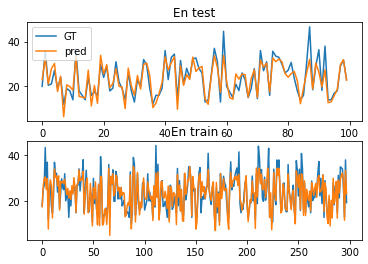

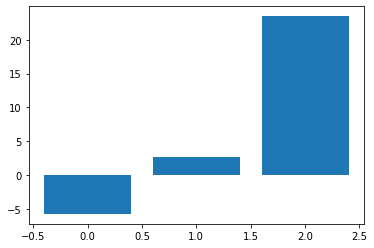

In [23]:
#on ne garde que le poids, l'année, et le biais
Xnew = np.hstack((Xe[:,3:4], Xe[:,5:]))
Xnew_t = np.hstack((Xe_t[:,3:4], Xe_t[:,5:]))
#on résout le système
A = np.dot(Xnew.T, Xnew)
B = np.dot(Xnew.T, y_train)
w = np.linalg.solve(A, B)
#on calcule les yhat et les yhat_t
yhat = np.dot(Xnew, w)
yhat_t = np.dot(Xnew_t, w)
#calcul de l'erreur
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t, y_test))
#et on affiche
plot_y(y_train, y_test, yhat, yhat_t)
plt.figure()
plt.bar(np.arange(len(w)), w)
plt.show()

Pas d'amélioration notable sur l'ensemble de test.
Résultats moins bons sur train ce qui est logique car on zappe une partie des données

Erreur moyenne au sens des moindres carrés (train): 8.73905008908377
Erreur moyenne au sens des moindres carrés (test): 10.77826270358948


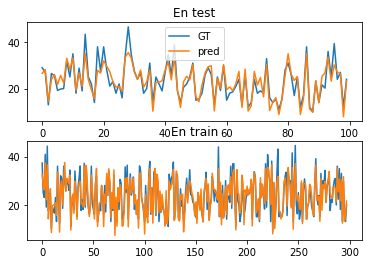

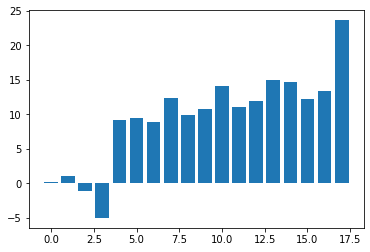

In [25]:
#on essaye avec l'origine
origine = data.values[:,-2]
N = len(origine)
origine = origine.reshape((N, 1))
origine = np.hstack((origine, np.zeros((N, 3), dtype=int)))
for o in range(N):
    origine[o, origine[o,0]] = 1
origine = origine[:,1:]

#encodage des années sur les 10 catégories
annees = data.values[:,-3]
#je crée mes 10 catégories
intervalles = np.linspace(min(annees), max(annees), 10)
#je remplis mes catégories
categories = np.zeros((len(annees),10), dtype=int)
for a in range(len(annees)):
    i = 0
    while annees[a] > intervalles[i]:
        i += 1
    categories[a][i] = 1
    
#données modifiées 
X = np.array(data.values[:,1:-4], dtype=np.float64)
X = np.hstack((X,categories))
X = np.hstack((X,origine))
y = np.array(data.values[:,0], dtype=np.float64)    
    
#séparation train/test et normalisation de toutes les données
#on travaille sur des copies pour ne rien modifier dans les jeux de données
X_train, y_train, X_test, y_test = separation_train_test(X, y, pc_train=0.75)
Xn_train, Xn_test = normalisation(X_train.copy(), X_test.copy())  

# résolution -> toujours pareil, comme avant 
Ye = y_train
A = np.dot(Xn_train.T, Xn_train)
B = np.dot(Xn_train.T, Ye)
w = np.linalg.solve(A, B)
#calcul des yhat et yhat_t
yhat = np.dot(Xn_train,w)
yhat_t = np.dot(Xn_test,w)

#calcul de l'erreur comme avant
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t, y_test))

#et on affiche
plot_y(y_train, y_test, yhat, yhat_t)
plt.figure()
plt.bar(np.arange(len(w)), w)
plt.show()


# Question d'ouverture sur le gradient

## La normalisation a-t-elle un impact sur le gradient?

La normalisation des données peut au moins nous aider à régler plus facilement le pas (qui sera toujours du même ordre de grandeur... Mais cela a-t-il un impact sur la manière dont nous nous rapprochons de la solution optimale?

## Gradient stochastique

Dans la plupart des algorithmes modernes d'optimisation liés aux réseaux de neurones, le gradient est calculé de manière stochastique, sur un exemple à la fois:

- $w_0 \leftarrow init$ par exemple : 0
- boucle
     - tirage d'une donnée $i$: $(x_i,y_i)$
     - $w_{t+1} \leftarrow w_{t} - \epsilon \nabla_w C_i(w)$


Etudier le fonctionnement de cet algorithme sur les exemples jouets précédents.

## Amélioration du gradient

Le blog de S. Ruder explique particulièrement bien les améliorations possibles sur les descentes de gradient.

https://ruder.io/optimizing-gradient-descent/

Comparer une descente de gradient stochastique avec et sans moment sur les données jouets des premières questions.